In [59]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm, tqdm_notebook

import sklearn
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import tensorflow as tf
import keras
import pickle
import gc

Using TensorFlow backend.


In [7]:
for p in [np, pd, sklearn, scipy, lgb, sns]:
    print (p.__name__, p.__version__)

numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
scipy 1.4.1
lightgbm 2.3.1
seaborn 0.10.0


In [29]:
from funs import downcast_dtypes, rmse, clip20, clip40

In [53]:
sales = pd.read_csv('data/sales_train.csv.gz')
shops = pd.read_csv('data/shops.csv')
items = pd.read_csv('data/items.csv')
item_cats = pd.read_csv('data/item_categories.csv')
test_data = pd.read_csv('data/test.csv.gz')

In [84]:
sample_submission = pd.read_csv('data/sample_submission.csv.gz')

In [36]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Exploratory Data Analysis

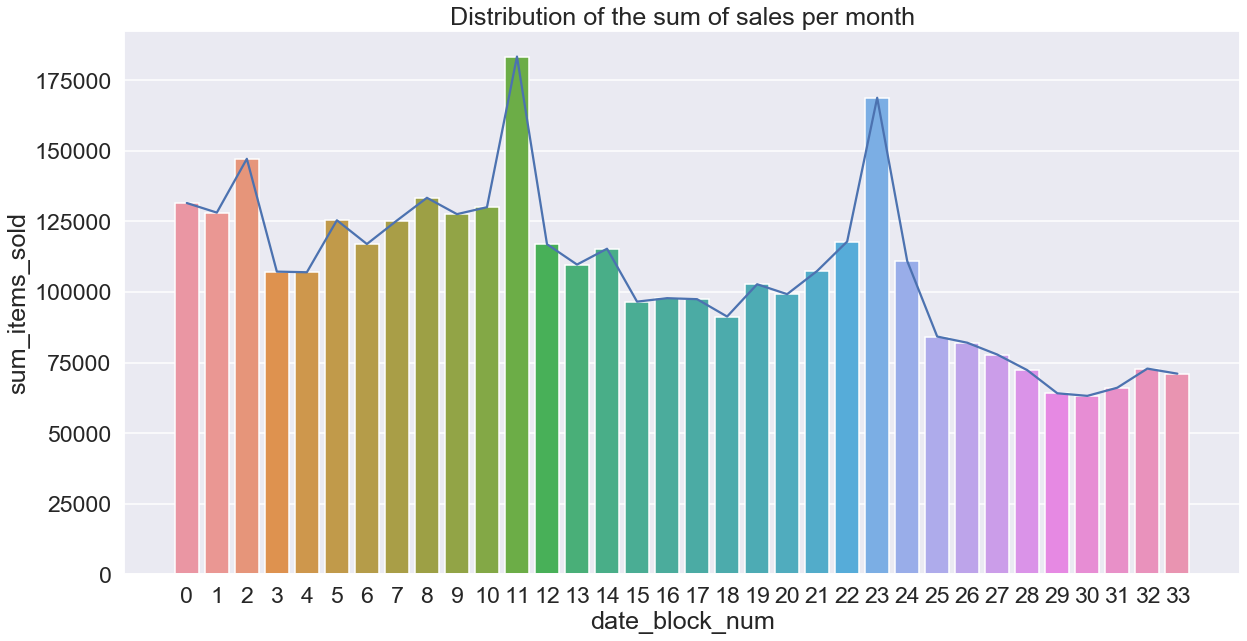

In [12]:
sns.set_context("talk", font_scale=1.4)
sales_month = pd.DataFrame(sales.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
sales_month.columns = ['date_block_num', 'sum_items_sold']
sns.barplot(x ='date_block_num', y='sum_items_sold', 
            data=sales_month.reset_index());
plt.plot(sales_month.sum_items_sold)
plt.title('Distribution of the sum of sales per month')
del sales_month

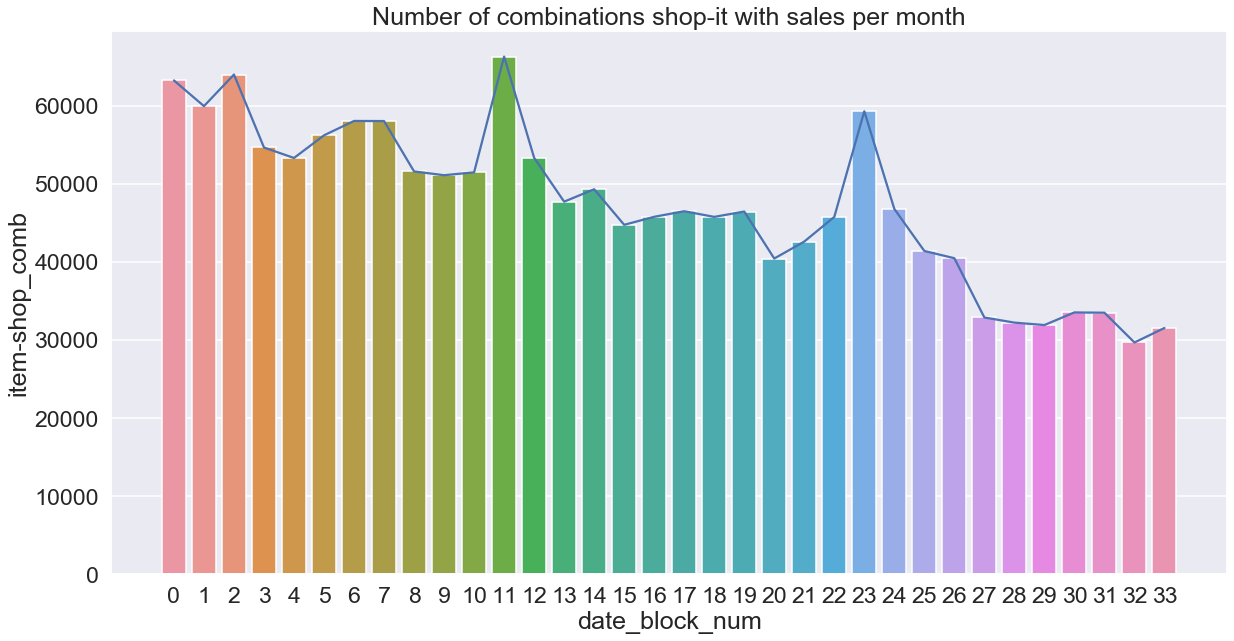

In [13]:
comb_shop_item = pd.DataFrame(sales[['date_block_num', 'shop_id', 
                                     'item_id']].drop_duplicates().groupby('date_block_num').size()).reset_index()
comb_shop_item.columns = ['date_block_num', 'item-shop_comb']
sns.barplot(x ='date_block_num', y='item-shop_comb', data=comb_shop_item);
plt.plot(comb_shop_item['item-shop_comb']);
plt.title('Number of combinations shop-it with sales per month')
del comb_shop_item

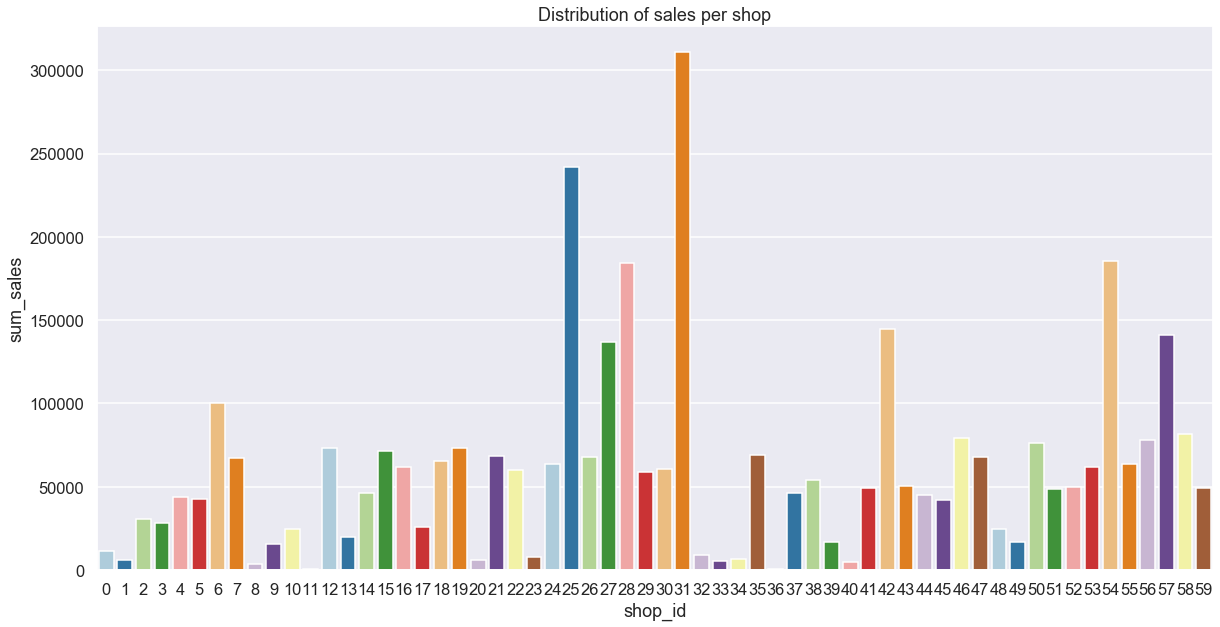

In [23]:
sns.set_context("talk", font_scale=1)
sales_month_shop_id = pd.DataFrame(sales.groupby(['shop_id']).sum().item_cnt_day).reset_index()
sales_month_shop_id.columns = ['shop_id', 'sum_sales']
sns.barplot(x ='shop_id', y='sum_sales', data=sales_month_shop_id, palette='Paired')
plt.title('Distribution of sales per shop');
del sales_month_shop_id

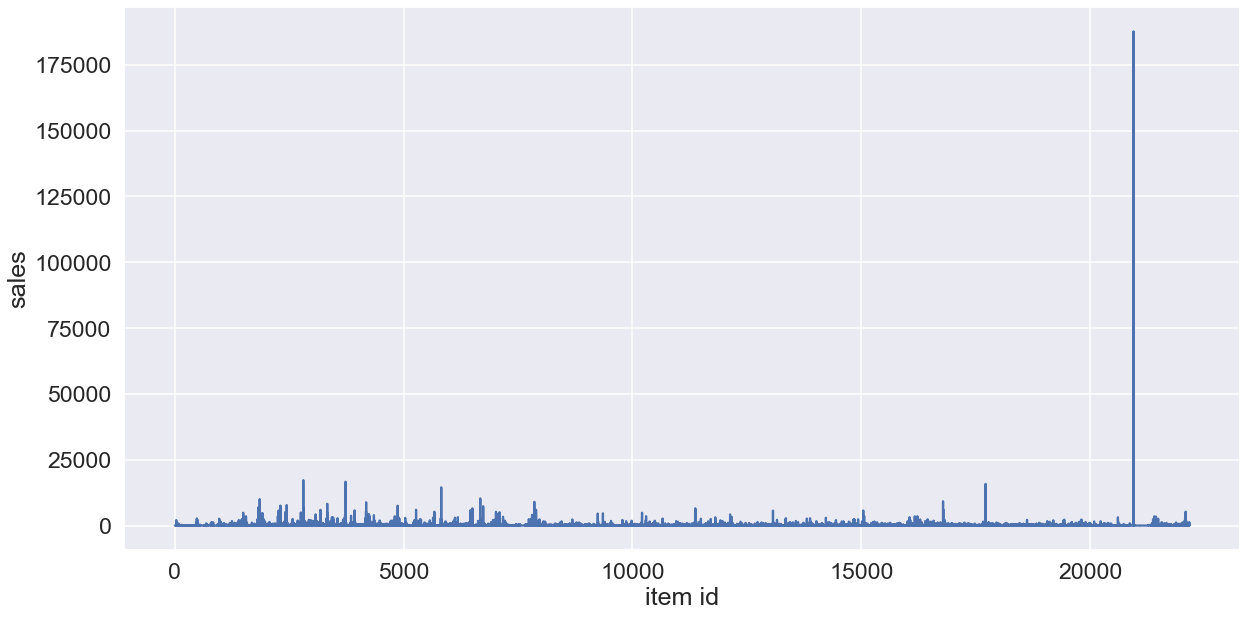

In [14]:
sns.set_context("talk", font_scale=1.4)
sales_item_id = pd.DataFrame(sales.groupby(['item_id']).sum().item_cnt_day)
plt.xlabel('item id')
plt.ylabel('sales')
plt.plot(sales_item_id);

In [15]:
tuples_df = pd.Series(list(sales[['item_id', 'shop_id']].itertuples(index=False, name=None)))
tuples_test = pd.Series(list(test_data[['item_id', 'shop_id']].itertuples(index=False, name=None)))
print(str(round(tuples_df.isin(tuples_test).sum()/len(tuples_df),2)*100)+'%')

42.0%


# Data leakage
We can clearly see that 42% of the shop id, item id combinations are present in the test set
Hence I will make my model accordingly

In [55]:
test_block = sales['date_block_num'].max() + 1
test_data['date_block_num'] = test_block
test_data = test_data.drop(columns=['ID'])
test_data.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [56]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)
grid = pd.concat([grid, test_data])

In [57]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols, as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target'})
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_shop'})
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].sum()
gb = gb.rename(columns={'item_cnt_day': 'target_item'})
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [52]:
all_data

,shop_id,item_id,date_block_num,ID,target,target_shop,target_item
0,59,22154,0,0.0,1.0,2017.0,18.0
1,59,2552,0,0.0,0.0,2017.0,0.0
2,59,2554,0,0.0,0.0,2017.0,1.0
3,59,2555,0,0.0,0.0,2017.0,2.0
4,59,2564,0,0.0,0.0,2017.0,5.0
...,...,...,...,...,...,...,...
11128045,45,18454,34,214195.0,0.0,0.0,0.0
11128046,45,16188,34,214196.0,0.0,0.0,0.0
11128047,45,15757,34,214197.0,0.0,0.0,0.0
11128048,45,19648,34,214198.0,0.0,0.0,0.0


In [60]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols))
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
del train_shift

In [61]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
0,59,22154,0,1.0,2017.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0.0,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0.0,2017.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0.0,2017.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0.0,2017.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12]

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
# We will drop these at fitting stage
to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']

# Category for each item
item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)

gc.collect()

533

In [75]:
target_range = [0,20]

# Final Data to be used


In [65]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


In [63]:
dates = all_data['date_block_num']

dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

In [66]:
X_train = all_data.loc[dates <  test_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  test_block, 'target'].values
y_test =  all_data.loc[dates == test_block, 'target'].values

# Modelling

## Linear model

In [67]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

In [68]:
pred_lr = clip20(pred_lr)

## LightGBM

In [69]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7,
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

In [70]:
pred_lgb = clip20(pred_lgb)

# Concatenate to get test meta features

In [71]:
X_test_level2 = np.c_[pred_lr, pred_lgb]

In [72]:
X_test_level2

array([[0.59513646, 0.45047173],
       [0.10165797, 0.15679661],
       [0.95515631, 0.84702682],
       ...,
       [0.08131603, 0.04771994],
       [0.1054668 , 0.04511831],
       [0.09177211, 0.04511831]])

In [73]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(dates_train_level2)]

## K fold scheme 

In [76]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    print(cur_block_num)
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    X_train_cur = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test_cur =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train_cur = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_cur =  all_data.loc[dates == cur_block_num, 'target'].values
    
    lr.fit(X_train_cur.values, y_train_cur)
    pred_lr = lr.predict(X_test_cur.values)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = pred_lr.clip(*target_range)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_cur, label=y_train_cur), 100)
    pred_lgb = model.predict(X_test_cur)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = pred_lgb.clip(*target_range)

27
28
29
30
31
32
33


# Simple averaging

In [77]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = []
for alpha in alphas_to_try:
    mix = alpha*X_train_level2[:,0] + (1-alpha)*X_train_level2[:,1]
    r2_scores.append(r2_score(y_train_level2, mix))

r2_scores = np.array(r2_scores)

best_alpha = alphas_to_try[r2_scores.argmax()]
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.044000; Corresponding r2 score on train: 0.083836


In [85]:
pred_simple_averaging = best_alpha*X_test_level2[:,0] + (1-best_alpha)*X_test_level2[:,1]
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_simple_averaging})
submission.to_csv('submission_simple_averaging.csv', index=False)